In [ ]:
!pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from google.colab import drive
import noisereduce as nr
import cv2
import math
import os
import tensorflow as tf
from tensorflow.keras import layers, models

from scipy.io import wavfile
os.chdir('/content')

Mounted at /content/drive


In [ ]:
file_name = "drive/Shareddrives/ML_final_team01/presentation_use_voice/0_30female_2.mp3"  #input

## 1.Gender prediction from voice

In [ ]:
def waveplot(path): 
  y, sr = librosa.load(path, sr = 20000)
  # reduce noise
  y_reduced = nr.reduce_noise(y=y, sr=sr)
  # trim silence
  y_trim, index = librosa.effects.trim(y_reduced, top_db = 20)
  duration = librosa.get_duration(y_trim)

  if duration * sr >= 30000:
    y_int = y_trim[0:30000] # fixed the length to 30000 sample.
  else:
    y_int = y_trim
    d = duration
    while d * sr < 30000:
        y_int = np.append(y_int, y_trim)
        d += duration
    y_int = y_int[0:30000]
    
  f0, _, _ = librosa.pyin(y_int, sr=sr, fmin=10, fmax=8000, frame_length=1024)

  return f0

In [ ]:
# preprocess the data
f0 = waveplot(file_name)
f = ((np.nanmean(f0), np.nanmedian(f0), np.nanstd(f0), np.nanpercentile(f0, 5), np.nanpercentile(f0, 95) ))
f = np.array(f)
f = f.reshape(1,5)
f = (f - 1.359040344925622) / (487.00182043715796 - 1.359040344925622)
 
assert(np.nanmax(f) <= 1), 'please re-input the voice!'

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
# use pre-trained model to predict
gender_model = models.load_model('drive/Shareddrives/ML_final_team01/gender_model')
gender_pred = gender_model.predict(f)
print("male : ", round(gender_pred[0][0] * 100, 1), "%")
print("female: ", round(gender_pred[0][1] * 100, 1), "%")
gender_pred = np.argmax(gender_pred)
print("the voice is from a" ,gender_pred == 0 and "male" or "female", '.')

1/1 [==============================] - 0s 44ms/step
male :  18.5 %
female:  81.5 %
the voice is from a female .


## 2.Use the gender prediction to prediction age

In [ ]:
male_pred_model = models.load_model('drive/Shareddrives/ML_final_team01/male-age-pred')
female_pred_model = models.load_model('drive/Shareddrives/ML_final_team01/female-age-pred')

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


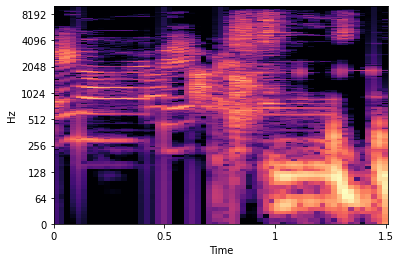

In [ ]:
# preprocess the voice to png
y, sr = librosa.load(file_name, sr = 20000)
y_reduced = nr.reduce_noise(y=y, sr=sr)
assert np.isfinite(y_reduced).all(), 'please re-input the voice!' # the y_reduced might not finite everywhere.
y_trim, index = librosa.effects.trim(y_reduced, top_db = 20)
interval = librosa.effects.split(y_trim, top_db=20, frame_length = 1024)
y_int = y_trim[interval[0][0]:interval[0][1]]
for j in range(1, len(interval)):
    y_int = np.append(y_int, y_trim[interval[j][0]:interval[j][1]])
duration = librosa.get_duration(y_int)
if duration * sr >= 30000:
    y_int = y_int[0:30000]
    x_stft = np.abs(librosa.stft(y_int))
    x_stft = librosa.amplitude_to_db(x_stft, ref = np.max)
    img = librosa.display.specshow(x_stft, sr = sr, x_axis = 'time', y_axis = 'log')
    plt.savefig('temp.png')
    
else:  
    y_sliced = y_int     # duplicate and concatenate to 30000 samples.
    d = duration
    while d * sr < 30000:
        y_sliced = np.append(y_sliced, y_int)
        d += duration
    y_sliced = y_sliced[0:30000]
    x_stft = np.abs(librosa.stft(y_sliced))
    x_stft = librosa.amplitude_to_db(x_stft, ref = np.max)
    img = librosa.display.specshow(x_stft, sr = sr, x_axis = 'time', y_axis = 'log')
    plt.savefig('temp.png')

In [ ]:
img = cv2.imread('temp.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert it to RGB format
img = img[35:251, 55:389]
if gender_pred == 0:
    print('using male model.')
    pred = male_pred_model.predict(img.reshape(1, 216, 334, 3))
elif gender_pred == 1:
    print('using female model.')
    pred = female_pred_model.predict(img.reshape(1, 216, 334, 3))
# print(pred)

using female model.
1/1 [==============================] - 0s 72ms/step


In [ ]:
age = ['0~30 years old', '30~50 years old', '50~70 years old', 'older than seventies']
outcome = (-pred[0]).argsort()[:2]
print("The voice is from", age[outcome[0]], '.')

#outcome = (-pred[0]).argsort()[:2]
#print(round(pred[0][outcome[0]] * 100, 1), "% from", age[outcome[0]])
#print(round(pred[0][outcome[1]] * 100, 1), "% from", age[outcome[1]])

The voice is from 0~30 years old .
